In [1]:
%load_ext autoreload
%autoreload 2

import wandb
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

import json 
import torch
print(f"Using GPU: {torch.cuda.get_device_name(0)}")

import pandas as pd

from handsoncv.datasets import CILPFusionDataset
from handsoncv.models import LidarClassifier, CILPModel, CrossModalProjector, RGB2LiDARClassifier
from handsoncv.training import train_fusion_cilp_model, search_checkpoint_model
from torchvision import transforms
from torch.utils.data import DataLoader

NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, "..", ".."))

ROOT_PATH = os.path.join(PROJECT_ROOT, "Assignment-2")
CHECKPOINTS_DIR = os.path.join(ROOT_PATH, "checkpoints")
ROOT_DATA = "~/Documents/repos/BuildingAIAgentsWithMultimodalModels/data/assessment/"
IMG_SIZE = 64
BATCH_SIZE = 32

Using GPU: NVIDIA GeForce RTX 3090


In [2]:
# Load split dictionary previouslu created with 01_dataset_exploration.ipynb
mapping_file = "subset_splits.json"
with open(f"{ROOT_PATH}/{mapping_file}", "r") as f:
    splits = json.load(f)
    
torch.manual_seed(splits["seed"])

# Instantiate Dataset
img_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),  # Scales data into [0,1]
])

train_ds = CILPFusionDataset(root_dir=ROOT_DATA, sample_ids=splits["train"], transform=img_transforms)
val_ds = CILPFusionDataset(root_dir=ROOT_DATA, sample_ids=splits["val"], transform=img_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

print(f"Ready to train with {len(train_ds)} training pairs and {len(val_ds)} validation pairs.")

Ready to train with 4799 training pairs and 1200 validation pairs.


In [3]:
###################################################################
# Sanity Check - Ensure no data leakage between train and val sets
###################################################################

assert set(train_ds.sample_ids).isdisjoint(set(val_ds.sample_ids)), "DATA LEAKAGE DETECTED!"

leaked_ids = set(train_ds.sample_ids).intersection(set(val_ds.sample_ids))
print(f"Found {len(leaked_ids)} overlapping IDs.")
print(f"Example leaked IDs: {list(leaked_ids)[:10]}")

train_labels = next(iter(train_loader))[-1].cpu().numpy()
val_labels = next(iter(val_loader))[-1].cpu().numpy()
class_prior_train, class_prior_val = train_labels.mean(), val_labels.mean()

print(f"Class prior average in first training batch: {class_prior_train:.4f}, and validation batch: {class_prior_val:.4f}")

if class_prior_train < 0.01 or class_prior_train > 0.99:
    raise ValueError("The training batch is extremely imbalanced "
        f"(class prior = {class_prior_train:.4f}). "
        "It will cause the model to memorize label ordering. "
        "Please recreate the dataset splits."
    )

Found 0 overlapping IDs.
Example leaked IDs: []
Class prior average in first training batch: 0.5312, and validation batch: 0.5625


In [4]:
# Configuration common to all subsequent steps
SUBSET_SIZE = len(train_ds) + len(val_ds) 
INTERM_FUSION_EMB_DIM = 200

### Step 5.1a: Train the LiDAR-Only Classifier

In [5]:
# Configuration to fufill logging requirement
EPOCHS = 20
LEARNING_RATE = 1e-4

run = wandb.init(
    project="handsoncv-cilp-assessment", 
    name="5.1a_Lidar_Only",
    config={
        "architecture": "LidarClassifier",
        "fusion_strategy": "single_modality",
        "learning_rate": LEARNING_RATE,
        "epochs": EPOCHS,
        "subset_size": SUBSET_SIZE
    }
)

# Instantiate Classifier on LiDAR images only
lidar_model = LidarClassifier(emb_dim_interm=INTERM_FUSION_EMB_DIM).to("cuda")
# lidar_model = Classifier(1).to("cuda")

optimizer = torch.optim.Adam(lidar_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

metrics_lidar = train_fusion_cilp_model(
    lidar_model, 
    train_loader, 
    val_loader, 
    optimizer=optimizer, 
    criterion=torch.nn.CrossEntropyLoss(),
    device="cuda" if torch.cuda.is_available() else "cpu",
    epochs=EPOCHS, 
    scheduler=scheduler, 
    task_mode="lidar-only"
)

wandb.finish()

wandb: Currently logged in as: guarino-vanessa-emanuela (handsoncv-research) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/lidar-only_best_model.pt
Epoch 0: Val Loss: 0.6507, Acc: 58.45% | Mem: 138.4MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/lidar-only_best_model.pt
Epoch 1: Val Loss: 0.4485, Acc: 78.12% | Mem: 138.4MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/lidar-only_best_model.pt
Epoch 2: Val Loss: 0.1744, Acc: 94.43% | Mem: 138.4MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/lidar-only_best_model.pt
Epoch 3: Val Loss: 0.0565, Acc: 98.99% | Mem: 138.4MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/lidar-only_best_model.pt
Epoch 4: Val Loss: 0.0179, Acc: 99.92% | Mem: 138.4MB
Saved new best model to /home/vanessa/Documen

accuracy,▁▄▇█████████████████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
epoch_time_sec,▆▃▂██▇█▂▂▂▂▂▂█▃▁▂▁▁▁
learning_rate,████▇▇▇▆▆▅▄▄▃▃▂▂▂▁▁▁
peak_gpu_mem_mb,▁▇▇▇▇▇▇▇▇▇▇▇▇▇██████
train_loss,█▇▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,100
epoch,19
epoch_time_sec,4.90078
learning_rate,0.0


### Step 5.1b: Contrastive Pretraining (CILP Alignment)

**Note on Initial Contrastive Loss.** In CILP, normalized RGB and LiDAR embeddings are scaled by a learnable temperature (`logit_scale.exp() ≈ 14.3`).  

For batch size `B=32`:

- Diagonal similarities (correct pairs) are higher than off-diagonal (negatives).  
- After scaling, softmax already favors correct pairs, giving an **initial validation loss around 0.8–1.0**.  

> This is lower than the classical InfoNCE baseline `log(B) ≈ 3.46` due to temperature scaling, which is expected and not a concern.

Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/contrastive_best_model.pt
Epoch 0: Val Loss: 0.8256, Acc: 0.00% | Mem: 392.6MB
Accuracy not applicable to the embedding alignment task -> Similarity matrix (first 8x8):
[[0.798 0.459 0.501 0.467 0.335 0.222 0.595 0.576]
 [0.329 0.833 0.65  0.588 0.277 0.525 0.341 0.606]
 [0.296 0.646 0.814 0.805 0.339 0.513 0.252 0.44 ]
 [0.298 0.639 0.799 0.812 0.331 0.493 0.246 0.427]
 [0.406 0.351 0.442 0.418 0.864 0.569 0.39  0.528]
 [0.193 0.606 0.546 0.524 0.592 0.87  0.357 0.432]
 [0.707 0.44  0.232 0.259 0.271 0.446 0.87  0.347]
 [0.431 0.743 0.562 0.445 0.502 0.469 0.332 0.857]]
Mean diag: 0.679, Mean off-diag: -0.088
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/contrastive_best_model.pt
Epoch 1: Val Loss: 0.6368, Acc: 0.00% | Mem: 392.6MB
Accuracy not applicable to the embedding alignment task -> Similarity matrix (f

accuracy,▁▁▁▁▁▁▁▁▁▁
epoch,▁▂▃▃▄▅▆▆▇█
epoch_time_sec,▄▂█▄▃▁▁▂▁▁
learning_rate,██▇▇▆▄▃▂▂▁
peak_gpu_mem_mb,▁█████████
train_loss,█▄▃▂▂▁▁▁▁▁
val_loss,█▆▄▃▂▂▁▁▁▁
accuracy,0
epoch,9
epoch_time_sec,5.57385
learning_rate,0.0


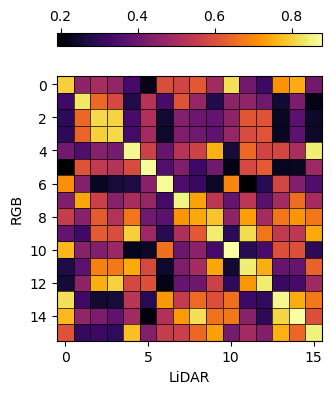

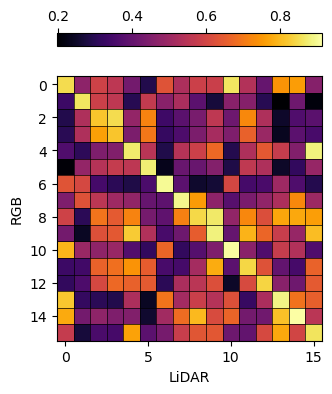

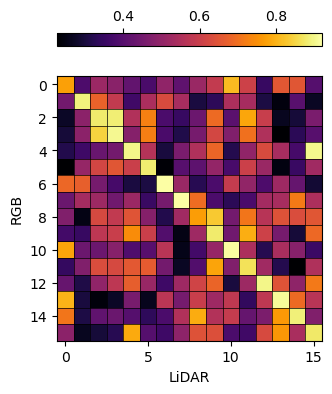

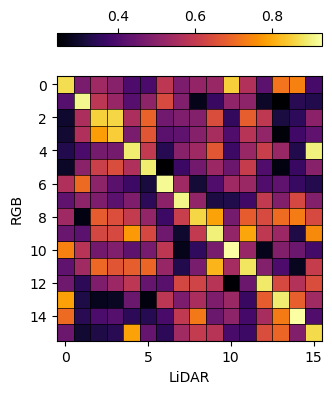

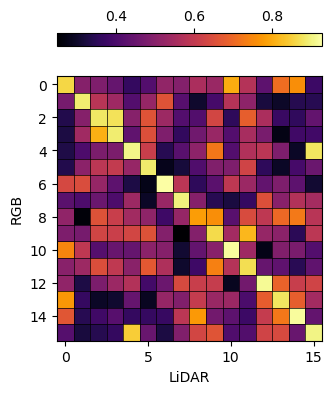

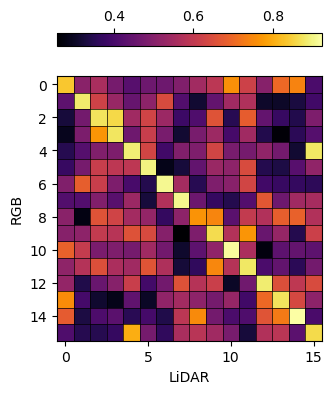

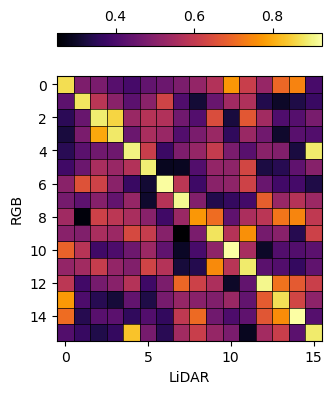

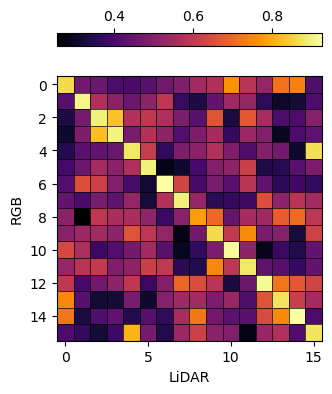

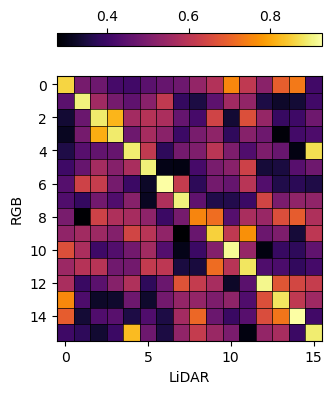

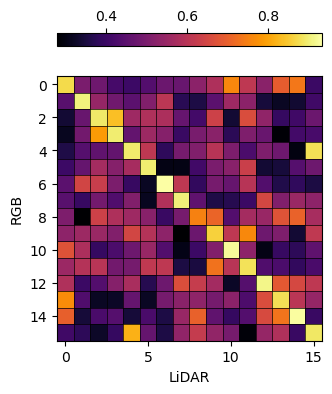

In [6]:
# Configuration to fufill logging requirement
# Choices based upon Nvidia 05_Assessment CILP training scheme
EPOCHS = 10
LEARNING_RATE = 1e-4 

run = wandb.init(
    project="handsoncv-cilp-assessment", 
    name="5.1b_CILP_Contrastive",
    config={
        "architecture": "CILPModel",
        "fusion_strategy": "contrastive",
        "learning_rate": LEARNING_RATE,
        "epochs": EPOCHS,
        "subset_size": SUBSET_SIZE
    }
)

cilp_model = CILPModel(emb_dim_interm=INTERM_FUSION_EMB_DIM, emb_dim_late=INTERM_FUSION_EMB_DIM).to("cuda")

optimizer = torch.optim.Adam(cilp_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

metrics_cilp = train_fusion_cilp_model(
    cilp_model, 
    train_loader, 
    val_loader, 
    optimizer=optimizer, 
    criterion=torch.nn.CrossEntropyLoss(), # CrossEntropy used for CILP too
    device="cuda", 
    epochs=EPOCHS, 
    scheduler=scheduler, 
    task_mode="contrastive"
)

# TASK 5.1b CHECK REQUIREMENT:
check_value = 0.8
if metrics_cilp['val_loss'] < check_value:
    print(f"✅ Success! CILP Val Loss {metrics_cilp['val_loss']:.4f} is below {check_value}")

wandb.finish()

### Step 5.2 Cross-Modal Projector

**Note on Cross-Modal Projector Validation Loss.**  In our setup, the projector maps RGB embeddings to LiDAR embeddings (`12800`-dim vectors). Due to the normalization of embeddings in the pretrained CILP model, the expected MSE for a randomly initialized projector is naturally **much lower than the 2.5 threshold** given in the assignment. Based on our observations, a practical and meaningful target for validation loss is `< 0.20`, which reflects effective learning progress of the projector aligning RGB embeddings to the LiDAR space.


In [5]:
new_lidar_model = LidarClassifier(emb_dim_interm=INTERM_FUSION_EMB_DIM).to("cuda")
new_cilp_model = CILPModel(emb_dim_interm=INTERM_FUSION_EMB_DIM, emb_dim_late=INTERM_FUSION_EMB_DIM).to("cuda")

lidar_model = search_checkpoint_model(CHECKPOINTS_DIR, instantiated_model= new_lidar_model, task_mode="lidar-only")
cilp_model = search_checkpoint_model(CHECKPOINTS_DIR, instantiated_model= new_cilp_model,task_mode="contrastive")

Loaded lidar-only model from checkpoint: /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/lidar-only_best_model.pt
        Using instantiated model in `.eval()` mode.
Loaded contrastive model from checkpoint: /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/contrastive_best_model.pt
        Using instantiated model in `.eval()` mode.


In [6]:
def estimate_random_mse(embedding_dim=12800, batch_size=32, device="cpu"):
    """Estimate MSE for untrained projector assuming random embeddings and L2-normalized target embeddings."""
    # Random unit vectors for target and projector output
    target = torch.randn(batch_size, embedding_dim, device=device)
    # target = target / target.norm(dim=1, keepdim=True)
    pred = torch.randn(batch_size, embedding_dim, device=device) 
    # pred = pred / pred.norm(dim=1, keepdim=True)
    
    print(torch.mean((pred - target)**2))
    
    mse = torch.mean((pred - target)**2).item()
    return mse

embedding_dim = 12800
batch_size = 32
random_mse = estimate_random_mse(embedding_dim, batch_size, device="cuda" if torch.cuda.is_available() else "cpu")
print(f"Estimated random MSE (per batch): {random_mse:.5f}")

tensor(2.0008, device='cuda:0')
Estimated random MSE (per batch): 2.00076


In [7]:
# Configuration to fufill logging requirement
# Choices based upon Nvidia 05_Assessment CILP training scheme
EPOCHS = 40
LEARNING_RATE = 1e-3

run = wandb.init(
    project="handsoncv-cilp-assessment", 
    name="5.2_Projector_MSE",
    config={
        "architecture": "CrossModalProjector",
        "fusion_strategy": "projector",
        "learning_rate": LEARNING_RATE,
        "epochs": EPOCHS
    }
)

# Lidar intermediate flat dimension: 200 * 8 * 8 = 12800
projector = CrossModalProjector(rgb_dim=INTERM_FUSION_EMB_DIM, lidar_dim=INTERM_FUSION_EMB_DIM * 8 * 8).to("cuda")

# We pass the frozen models to the loop via cilp_extras
extras = {
    'img_enc': cilp_model.img_embedder, 
    'lidar_cnn': lidar_model 
}

optimizer = torch.optim.Adam(projector.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

metrics_proj = train_fusion_cilp_model(
    projector, 
    train_loader, 
    val_loader, 
    optimizer=optimizer, 
    criterion=torch.nn.MSELoss(), # Projector criterion: MSE
    device="cuda", 
    epochs=EPOCHS, 
    task_mode="projector", 
    scheduler=scheduler,
    cilp_extras=extras
)

# TASK 5.2 CHECK REQUIREMENT:
check_value = .39  - (.55*.39) # Set a target of reducing the initial validation MSE by 55%.
if metrics_proj['val_loss'] < check_value:
    print(f"✅ Success! Projector MSE {metrics_proj['val_loss']:.4f} is below {check_value}")

wandb.finish()

wandb: Currently logged in as: guarino-vanessa-emanuela (handsoncv-research) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/projector_best_model.pt
Epoch 0: Val Loss: 0.2146, Acc: 0.00% | Mem: 1172.7MB
Accuracy not applicable to the cross-modal projector task
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/projector_best_model.pt
Epoch 1: Val Loss: 0.1875, Acc: 0.00% | Mem: 1172.7MB
Accuracy not applicable to the cross-modal projector task
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/projector_best_model.pt
Epoch 2: Val Loss: 0.1749, Acc: 0.00% | Mem: 1172.7MB
Accuracy not applicable to the cross-modal projector task
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/projector_best_model.pt
Epoch 3: Val Loss: 0.1627, Acc: 0.00% | Mem: 1172.7MB
Accuracy not applicable to the cross-modal projector task
Epoch 4:

accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch_time_sec,▆▄▄▃▁▄▄██▅▅▃▃▃▄▃▁▄▄▄▃▃▄▃▃▄▃▃▃▁▄▁▄▄▃▃▄▃▄▄
learning_rate,███████▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
peak_gpu_mem_mb,▁▆▆▆▆███████████████████████████████████
train_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0
epoch,39
epoch_time_sec,6.11507
learning_rate,0.0


### Step 5.3 Final Classifier Fine-Tuning 

In [5]:
new_lidar_model = LidarClassifier(emb_dim_interm=INTERM_FUSION_EMB_DIM).to("cuda")
new_cilp_model = CILPModel(emb_dim_interm=INTERM_FUSION_EMB_DIM, emb_dim_late=INTERM_FUSION_EMB_DIM).to("cuda")
new_projector = CrossModalProjector(rgb_dim=INTERM_FUSION_EMB_DIM, lidar_dim=INTERM_FUSION_EMB_DIM * 8 * 8).to("cuda")

lidar_model = search_checkpoint_model(CHECKPOINTS_DIR, instantiated_model= new_lidar_model, task_mode="lidar-only")
cilp_model = search_checkpoint_model(CHECKPOINTS_DIR, instantiated_model= new_cilp_model,task_mode="contrastive")
projector = search_checkpoint_model(CHECKPOINTS_DIR, instantiated_model= new_projector, task_mode="projector")

Loaded lidar-only model from checkpoint: /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/lidar-only_best_model.pt
        Using instantiated model in `.eval()` mode.
Loaded contrastive model from checkpoint: /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/contrastive_best_model.pt
        Using instantiated model in `.eval()` mode.
Loaded projector model from checkpoint: /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/projector_best_model.pt
        Using instantiated model in `.train()` mode.


In [6]:
# Configuration to fufill logging requirement
# Choices based upon Nvidia 05_Assessment CILP training scheme
EPOCHS = 50
LEARNING_RATE = 1e-2

run = wandb.init(
    project="handsoncv-cilp-assessment", 
    name="5.3_Fine-tuning_Lidar_Only",
    config={
        "architecture": "RGB2LiDARClassifier",
        "fusion_strategy": "fine-tuning",
        "learning_rate": LEARNING_RATE,
        "epochs": EPOCHS
    }
)

# Lidar intermediate flat dimension: 200 * 8 * 8 = 12800
final_cilp_classifier = RGB2LiDARClassifier(rgb_enc=cilp_model.img_embedder, projector=projector, lidar_classifier=lidar_model).to("cuda")

optimizer = torch.optim.Adam(final_cilp_classifier.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

metrics_proj = train_fusion_cilp_model(
    final_cilp_classifier, 
    train_loader, 
    val_loader, 
    optimizer=optimizer, 
    criterion=torch.nn.CrossEntropyLoss(), # Classifier criterion: CE
    device="cuda", 
    epochs=EPOCHS, 
    task_mode="fine-tuning", 
    scheduler=scheduler,
)

# TASK 5.3 CHECK REQUIREMENT:
check_value = 0.95
if metrics_proj['accuracy']/100 > check_value:
    print(f"✅ Success! Validation accuracy is {metrics_proj['accuracy']:.2f}% after fine-tuning, above {check_value}")

wandb.finish()

wandb: Currently logged in as: guarino-vanessa-emanuela (handsoncv-research) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fine-tuning_best_model.pt
Epoch 0: Val Loss: 0.4632, Acc: 78.04% | Mem: 1167.1MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fine-tuning_best_model.pt
Epoch 1: Val Loss: 0.3400, Acc: 86.15% | Mem: 1167.1MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fine-tuning_best_model.pt
Epoch 2: Val Loss: 0.3088, Acc: 87.08% | Mem: 1167.1MB
Saved new best model to /home/vanessa/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/checkpoints/fine-tuning_best_model.pt
Epoch 3: Val Loss: 0.2875, Acc: 87.84% | Mem: 1167.1MB
Epoch 4: Val Loss: 0.3111, Acc: 86.32% | Mem: 1167.1MB
Epoch 5: Val Loss: 0.3885, Acc: 84.46% | Mem: 1167.1MB
Epoch 6: Val Loss: 0.3184, Acc: 87.08% | Mem: 1167.1MB
Saved new best model to /home/vanessa/Documents/repos/Applied-H

accuracy,▁▅▅▆▅▅▆▆▆▅▄▅▆▆▆▆▆▇▆▇█▇▇▇█▇██████████████
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
epoch_time_sec,▇█▇▂▂▄▄▁▁▂▆▆▁▅▅▅▇▂▁▄▄▁▁▄▂▁▃▁▁▂▁▆▅▄▅▅▆▅▅▅
learning_rate,████████▇▇▇▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
peak_gpu_mem_mb,▁▇▇▇▇███████████████████████████████████
train_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▄▂▂▃▅▄▃▂▂▂▂▃▂▂▁▂▂▁▂▁▃▁▁▁▂▁▂▂▂▂▂▂▂▂▂
accuracy,92.14527
epoch,49
epoch_time_sec,6.32282
learning_rate,1e-05


In [7]:
# Assemble the final model
# We take the frozen RGB encoder from CILP, the trained Projector, and the trained Lidar classifier head
final_cilp_classifier = RGB2LiDARClassifier(
    rgb_enc=cilp_model.img_embedder, 
    projector=projector, 
    lidar_classifier=lidar_model
).to("cuda")

final_cilp_classifier.eval()

correct = 0
total = 0
batch_count = 0

print("Testing final classifier on 5 validation batches...")

with torch.no_grad():
    for rgb, _, labels in val_loader:
        if batch_count >= 5: break # Requirement: Test on at least 5 batches
        
        rgb, labels = rgb.to("cuda"), labels.to("cuda")
        outputs = final_cilp_classifier(rgb)
        _, predicted = torch.max(outputs.data, 1)
        
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        batch_count += 1

final_acc = 100 * correct / total
print(f"\nFinal Results (Transfer Learning RGB -> Projector -> LiDAR Head):")
print(f"Accuracy: {final_acc:.2f}%")

if final_acc > 95.0:
    print("✅ Success! Accuracy is above 95%")
else:
    print("❌ Accuracy below 95%. Consider training CILP or Projector for more epochs.")

Testing final classifier on 5 validation batches...

Final Results (Transfer Learning RGB -> Projector -> LiDAR Head):
Accuracy: 90.62%
❌ Accuracy below 95%. Consider training CILP or Projector for more epochs.


In [8]:
final_acc

90.625